Different gpu chips are spun up each time but the virtual disk is preserved. this can lead to errors like out-of memory etc:

## Cleaning prior to starting

In [1]:
import os
import shutil
import subprocess

def get_disk_usage(path="/"):
    """Returns disk usage in GB."""
    total, used, free = shutil.disk_usage(path)
    return {
        "total_GB": round(total / (2**30), 2),
        "used_GB": round(used / (2**30), 2),
        "free_GB": round(free / (2**30), 2)
    }

def clean_directories(directories):
    """Deletes contents of specified directories."""
    for dir_path in directories:
        if os.path.exists(dir_path):
            for filename in os.listdir(dir_path):
                file_path = os.path.join(dir_path, filename)
                try:
                    if os.path.isfile(file_path) or os.path.islink(file_path):
                        os.unlink(file_path)
                    elif os.path.isdir(file_path):
                        shutil.rmtree(file_path)
                except Exception as e:
                    print(f"Failed to delete {file_path}: {e}")

# Directories to clean
temp_dirs = [
    "/tmp",
    os.path.expanduser("~/temp"),
    os.path.expanduser("~/cache"),
    os.path.expanduser("~/Downloads"),
    os.path.expanduser("~/scratch")  # Add any custom paths you use
]

print("Disk usage before cleanup:", get_disk_usage())
clean_directories(temp_dirs)
print("Disk usage after cleanup:", get_disk_usage())


Disk usage before cleanup: {'total_GB': 118.05, 'used_GB': 72.34, 'free_GB': 45.7}
Failed to delete /tmp/systemd-private-824cb1c760d149918533a4b48058c23a-earlyoom.service-v9Ayxx: [Errno 13] Permission denied: '/tmp/systemd-private-824cb1c760d149918533a4b48058c23a-earlyoom.service-v9Ayxx'
Disk usage after cleanup: {'total_GB': 118.05, 'used_GB': 72.34, 'free_GB': 45.7}


## Setup AzureML Environment and Clone Repository


Select your compute, set up and choose an a100 instance. Call it a100instance.

Select the kernel option for python 3.10 - Pytorch and Tensorflow

Look under "connections", where you need to add your blob container as a datastore, and to authenticate your git credentials (associate with azure).

Under notebooks, below files / samples, there are 5 icons. One of those is the terminal. Open that and git clone your repository there. You will need to authenticate with a PAT (token).



In [2]:
print("This is how you need to build an environment in azure ml")
print(os.getcwd())

from azureml.core import Environment, Workspace
from azureml.core.conda_dependencies import CondaDependencies
import os
import subprocess
!sudo apt-get install libgl1-mesa-glx


# Set up the workspace
ws = Workspace.get(name="citdsdp4000nc6s-mlw",
                   subscription_id="25c7e1b1-ff04-418b-842b-29a58e065da7",
                   resource_group="CIT-DS-RG-DP4000-NC6S")

environment_name = "PIUGDetailedClassify22"
version=2
try:
    # Attempt to retrieve the environment
    Environment.get(workspace=ws, name=environment_name, version=version)
    environment_exists=True  # Environment exists
except Exception:
    environment_exists=False
print(environment_exists)

env = Environment(name=environment_name)


# Set up Conda dependencies
conda_dep = CondaDependencies()

# Specify Python version here!
conda_dep.add_conda_package("python=3.11")

requirements_file = "requirements_azure.txt"

with open(requirements_file, "r") as file:
    for line in file:
        package = line.strip()
        print(package)
        if package and not package.startswith("#"):  # Ignore comments and empty lines
            conda_dep.add_pip_package(package)

env.python.conda_dependencies = conda_dep

env.register(workspace=ws)
compute_name = "a100PIUG" # The env is not specific to a compute. BUILDING the env needs a compute
# We probably want a cluster of Standard_NC8as_T4_v3 instead.

# Build the environment
if environment_exists==False:
    print('submitting a job to build your environment. Check "Jobs"')
    env.build(ws, compute_name)


This is how you need to build an environment in azure ml
/mnt/batch/tasks/shared/LS_root/mounts/clusters/a100piug/code/Users/joseph.ribeiro/plankton_imager_classifier
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
The following packages were automatically installed and are no longer required:
  apport-symptoms bind9-utils dns-root-data gyp libaec-dev libaec0
  libhdf5-103-1 libhdf5-cpp-103-1 libhdf5-fortran-102 libhdf5-hl-100
  libhdf5-hl-cpp-100 libhdf5-hl-fortran-100 libjs-events libjs-inherits
  libjs-is-typedarray libjs-psl libjs-source-map libjs-sprintf-js
  libjs-typedarray-to-buffer libnode-dev libsz2 libuv1-dev node-abab
  node-abbrev node-agent-base node-ansi-regex node-ansi-styles node-ansistyles
  node-aproba node-archy node-are-we-there-yet node-argparse node-arrify
  node-asap node-asynckit node-balanced-match node-brace-expansion
  node-builtins node-

## Testing to see if the env can load the required modules

In [3]:
from azureml.core import ScriptRunConfig, Experiment, ComputeTarget

compute_target = ComputeTarget(workspace=ws, name="a100PIUG")

src = ScriptRunConfig(
    source_directory=".",
    script="test_env.py",
    compute_target=compute_target,
    environment=env  # your built environment object
)

experiment = Experiment(workspace=ws, name="env_test_run")
run = experiment.submit(config=src)

print("🚀 Job submitted. Check the 'Jobs' tab in Azure ML Studio.")

Submitting /mnt/batch/tasks/shared/LS_root/mounts/clusters/a100piug/code/Users/joseph.ribeiro/plankton_imager_classifier directory for run. The size of the directory >= 25 MB, so it can take a few minutes.


🚀 Job submitted. Check the 'Jobs' tab in Azure ML Studio.


## Connecting to the survey directory

In [4]:
from azureml.core import Workspace, Datastore

# 1️⃣ Connect to your current workspace
ws = Workspace.from_config()

# 2️⃣ Access your datastore by name
datastore = Datastore.get(ws, datastore_name='ced1025meggs')

# 3️⃣ Display its properties
print("Datastore name:", datastore.name)
print("Datastore type:", datastore.datastore_type)
print("Container name:", datastore.container_name)
print("Account name:", datastore.account_name)
print("Created by: James Scott")  # metadata is not automatically stored in v1


Datastore name: ced1025meggs
Datastore type: AzureBlob
Container name: cend-10-25-megsneps-earlysummer-northsea
Account name: citprodc8603uksa
Created by: James Scott


In [5]:
from azureml.core import Workspace, Datastore 
from azure.storage.blob import BlobServiceClient 
import pandas as pd 
from io import StringIO 
import tarfile 
import os


container_name = 'cend-10-25-megsneps-earlysummer-northsea' 
datastore_name = 'ced1025meggs'

datastore = Datastore.get(ws, datastore_name)

blob_account_name = datastore.account_name 
blob_account_token = datastore.sas_token
# print(datastore.sas_token)
blob_service_client = BlobServiceClient( account_url=f"https://{blob_account_name}.blob.core.windows.net", credential=blob_account_token )

container_client = blob_service_client.get_container_client(container_name)

# An example of how to upload file to blob storage (to extract the results or outputs after a job run)
#if False:
#    with open("/mnt/batch/tasks/shared/LS_root/mounts/clusters/a100instance/code/Users/joseph.ribeiro//outputs/classifications.csv", "rb") as data:
#        container_client.upload_blob(name="classifications.csv", data=data, overwrite=True)
#    print(f"File classifications.csv has been uploaded to Blob Storage. done.")

from azure.storage.blob import BlobClient

# Define the blob name and content
blob_name = "AzureML-testwriteability.txt"
content = "Hello from Azure ML! I could really use a chocolate digestive"

# Create a BlobClient
blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)



# Upload the text content
blob_client.upload_blob(content, overwrite=True)

print(f"✅ Uploaded '{blob_name}' to container '{container_name}'")


✅ Uploaded 'AzureML-testwriteability.txt' to container 'cend-10-25-megsneps-earlysummer-northsea'


In [6]:
from azure.storage.blob import BlobClient

# Define the blob name
blob_name = "AzureML-testwriteability.txt"

# Create a BlobClient for the file
blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)

# Download the blob content
downloaded_data = blob_client.download_blob().readall()

# Convert bytes to string
content = downloaded_data.decode("utf-8")

print(f"✅ Read content from '{blob_name}':")
print(content)

✅ Read content from 'AzureML-testwriteability.txt':
Hello from Azure ML! I could really use a chocolate digestive


In [7]:
import pandas as pd
import os
import sys

blob_names = []
print("✅ Listing all .tar blobs in container:")

# Only include blobs that end with .tar
for i, blob in enumerate(container_client.list_blobs(), start=1):
    if blob.name.endswith(".tar"):
        blob_names.append(blob.name)
    # overwrite the same line with progress info
    print(f"🟢 Scanned {i} blobs...", end="\r", flush=True)

print(f"\n✅ Total .tar blobs found: {len(blob_names)}")

data = []
for i, name in enumerate(blob_names, start=1):
    # Get blob size
    blob_client = blob_service_client.get_blob_client(container=container_name, blob=name)
    props = blob_client.get_blob_properties()
    size_mb = round(props.size / (1024 * 1024), 2)

    # Extract datetime safely
    if '/' in name:
        date_part, file_part = name.split('/', 1)
        time_part = file_part.replace('.tar', '')
        formatted_time = f"{time_part[:2]}:{time_part[2:]}" if len(time_part) == 4 else ""
        full_datetime = f"{date_part} {formatted_time}"
    else:
        full_datetime = ""

    data.append({"path": name, "datetime": full_datetime, "size_MB": size_mb})

    # show live progress without spamming
    print(f"📦 Processed {i}/{len(blob_names)} .tar files...", end="\r", flush=True)

print(f"\n✅ Finished processing all {len(blob_names)} .tar blobs")

# Save results
df = pd.DataFrame(data)
output_file = "blob_paths_with_sizes.csv"
df.to_csv(output_file, index=False)

print(f"✅ DataFrame saved to {os.path.abspath(output_file)}")
print(df.head())


✅ Listing all .tar blobs in container:
🟢 Scanned 7094 blobs...
✅ Total .tar blobs found: 2458
📦 Processed 2458/2458 .tar files...
✅ Finished processing all 2458 .tar blobs
✅ DataFrame saved to /mnt/batch/tasks/shared/LS_root/mounts/clusters/a100piug/code/Users/joseph.ribeiro/plankton_imager_classifier/blob_paths_with_sizes.csv
                  path          datetime  size_MB
0  2025-06-01/0734.tar  2025-06-01 07:34  2068.06
1  2025-06-01/0740.tar  2025-06-01 07:40  2632.46
2  2025-06-01/0750.tar  2025-06-01 07:50  2415.18
3  2025-06-01/0800.tar  2025-06-01 08:00  3026.76
4  2025-06-01/0810.tar  2025-06-01 08:10  1679.07


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Listing the .tar files and their sizes

📈 Summary statistics of blob sizes (MB):
count     2458.000000
mean      2503.113784
std       2414.844638
min          0.030000
25%        538.612500
50%       1582.540000
75%       4145.420000
max      20876.350000
Name: size_MB, dtype: float64


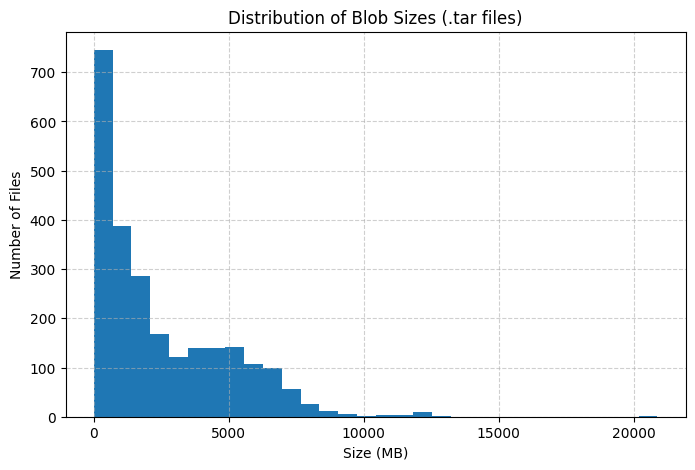

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# --- (Assuming your df is already created as in your code) ---
print("📈 Summary statistics of blob sizes (MB):")
print(df["size_MB"].describe())

# --- Plot the distribution ---
plt.figure(figsize=(8, 5))
plt.hist(df["size_MB"], bins=30)
plt.title("Distribution of Blob Sizes (.tar files)")
plt.xlabel("Size (MB)")
plt.ylabel("Number of Files")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


## Finding the tenth smallest for a test

In [9]:
# Sort by size
df_sorted = df.sort_values(by="size_MB", ascending=True).reset_index(drop=True)

# Check if there are at least 10 blobs
if len(df_sorted) >= 10:
    tenth_smallest = df_sorted.iloc[9]  # 0-indexed, so index 9 = 10th smallest
    print("🔟 10th smallest blob:")
    print(tenth_smallest)
else:
    print(f"⚠️ Only {len(df_sorted)} blobs found — fewer than 10 available.")


🔟 10th smallest blob:
path        2025-06-11/0940.tar
datetime       2025-06-11 09:40
size_MB                   68.76
Name: 9, dtype: object


In [22]:
# Defining tars in the way I did previously


from azureml.core import Dataset, Experiment, Workspace
from azureml.core.compute import ComputeTarget
from azureml.core.script_run_config import ScriptRunConfig
from azureml.core.environment import Environment

# Filter blobs that are .tar files only
tar_blobs = [blob for blob in container_client.list_blobs() if blob.name.endswith('.tar')]

i=0
for blob in tar_blobs:
    i=i+1
    if i>0:
        folder_name = blob.name

        # Register dataset
        dataset = Dataset.File.from_files(path=(datastore, '/' + folder_name))
        dataset = dataset.register(workspace=ws, name=folder_name, create_new_version=True)
        dataset = Dataset.get_by_name(ws, name=folder_name)
        print("Dataset registered for .tar file:", folder_name)

        # Configure and submit job


        src = ScriptRunConfig(
            source_directory="./",
            script="plankton_inference_single_tar.py",
            arguments=[
                "--tar_file", "/mnt/tar_files/<specific_tar>.tar",  
                "--model_weights", 'Plankton_imager_v03_stage-2_Best',
                "--train_dataset", "data/dummy_train",
                "--cruise_name", "MEGGS25",
                "--batch_size", 32,
                "--density_constant", 1.0,
                '--wsname', 'citdsdp4000nc6s-mlw',
                '--wssubscription_id', '25c7e1b1-ff04-418b-842b-29a58e065da7',
                '--wsresource_group', 'CIT-DS-RG-DP4000-NC6S',
                '--dsname', folder_name,
                '--datastorename', datastore_name],
            compute_target=compute_target,
            environment=env
        )        


        experiment = Experiment(workspace=ws, name='bigger-gpu-experiment')
        run = experiment.submit(config=src)
        run.wait_for_completion(show_output=True)

Dataset registered for .tar file: 2025-06-01/0734.tar
RunId: bigger-gpu-experiment_1763988990_2d396330
Web View: https://ml.azure.com/runs/bigger-gpu-experiment_1763988990_2d396330?wsid=/subscriptions/25c7e1b1-ff04-418b-842b-29a58e065da7/resourcegroups/cit-ds-rg-dp4000-nc6s/workspaces/citdsdp4000nc6s-mlw&tid=eeea3199-afa0-41eb-bbf2-f6e42c3da7cf

Streaming user_logs/std_log.txt

/azureml-envs/azureml_970145c94772fd52fe2445ed9767407a/lib/python3.11/site-packages/azureml/core/__init__.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-06-01/0734.tar
Workspace.create(name='citdsdp4000nc6s-mlw', subscription_id='25c7e1b1-ff04-418b-842b-29a58e065da7', resource_group='CIT-DS-RG-DP4000-NC6S')
{'infer_column_types': 'False', 'activity': 'download'}
{'infer_column_types': '

Submitting /mnt/batch/tasks/shared/LS_root/mounts/clusters/a100piug/code/Users/joseph.ribeiro/plankton_imager_classifier directory for run. The size of the directory >= 25 MB, so it can take a few minutes.


ActivityFailedException: ActivityFailedException:
	Message: Activity Failed:
{
    "error": {
        "code": "UserError",
        "message": "Execution failed. User process '/azureml-envs/azureml_970145c94772fd52fe2445ed9767407a/bin/python' exited with status code 1. Please check log file 'user_logs/std_log.txt' for error details. Error: Traceback (most recent call last):\n  File \"<string>\", line 197, in <module>\n  File \"<string>\", line 193, in main\n  File \"<frozen runpy>\", line 291, in run_path\n  File \"<frozen runpy>\", line 98, in _run_module_code\n  File \"<frozen runpy>\", line 88, in _run_code\n  File \"plankton_inference_single_tar.py\", line 248, in <module>\n    df_result.to_csv(output_path, index=False)\n    ^^^^^^^^^^^^^^^^\nAttributeError: 'tuple' object has no attribute 'to_csv'\n\n",
        "messageParameters": {},
        "details": []
    },
    "time": "0001-01-01T00:00:00.000Z",
    "componentName": "CommonRuntime"
}
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Activity Failed:\n{\n    \"error\": {\n        \"code\": \"UserError\",\n        \"message\": \"Execution failed. User process '/azureml-envs/azureml_970145c94772fd52fe2445ed9767407a/bin/python' exited with status code 1. Please check log file 'user_logs/std_log.txt' for error details. Error: Traceback (most recent call last):\\n  File \\\"<string>\\\", line 197, in <module>\\n  File \\\"<string>\\\", line 193, in main\\n  File \\\"<frozen runpy>\\\", line 291, in run_path\\n  File \\\"<frozen runpy>\\\", line 98, in _run_module_code\\n  File \\\"<frozen runpy>\\\", line 88, in _run_code\\n  File \\\"plankton_inference_single_tar.py\\\", line 248, in <module>\\n    df_result.to_csv(output_path, index=False)\\n    ^^^^^^^^^^^^^^^^\\nAttributeError: 'tuple' object has no attribute 'to_csv'\\n\\n\",\n        \"messageParameters\": {},\n        \"details\": []\n    },\n    \"time\": \"0001-01-01T00:00:00.000Z\",\n    \"componentName\": \"CommonRuntime\"\n}"
    }
}

In [ ]:
from azureml.core import Workspace, Environment, Dataset


tar_dataset = Dataset.File.from_files(path=(datastore, '/*.tar'))  # adjust path if needed
tar_dataset = tar_dataset.register(workspace=ws, name='Plankton_tar_files', create_new_version=True)


# Register models dataset
models_container_name = 'models' 
models_datastore_name = 'models'
models_datastore = Datastore.get(ws, models_datastore_name)
models_blob_account_name = models_datastore.account_name 
models_blob_account_token = models_datastore.sas_token
models_blob_service_client = BlobServiceClient( account_url=f"https://{models_blob_account_name}.blob.core.windows.net", credential=models_blob_account_token )
models_container_client = models_blob_service_client.get_container_client(models_container_name)
#register model as a dataset
models_dataset = Dataset.File.from_files(path=(models_datastore, '/Plankton_imager_v03_stage-2_Best.pth'))
models_dataset = models_dataset.register(workspace=ws, name='Plankton_imager_v03_stage-2_Best', create_new_version=True)
models_dataset = Dataset.get_by_name(ws, name='Plankton_imager_v03_stage-2_Best')
print()

#env = Environment.get(workspace=ws, name="PIUGDetailedClassify")
#env.python.conda_dependencies.add_pip_package("numpy<1.25")
#env.register(workspace=ws)

from azureml.core import Workspace, Experiment, Environment, ScriptRunConfig, Dataset, ComputeTarget

import pandas as pd

# Path to your CSV
df = pd.read_csv("blob_paths_with_sizes.csv")
df = df[df['path'].str.endswith(".tar")].sort_values("size_MB").reset_index(drop=True)
tenth_blob_path = df.iloc[9]['path']  # 10th smallest
print(tenth_blob_path)
print("10th smallest blob path:", tenth_blob_path)

ws = Workspace.get(
    name="citdsdp4000nc6s-mlw",
    subscription_id="25c7e1b1-ff04-418b-842b-29a58e065da7",
    resource_group="CIT-DS-RG-DP4000-NC6S"
)
print("Workspace loaded:", ws.name)


compute_name = "a100PIUG"  # replace with your AML compute name
compute_target = ComputeTarget(workspace=ws, name=compute_name)


from azureml.core import Environment

env = Environment.get(workspace=ws, name="PIUGDetailedClassify2")



src = ScriptRunConfig(
    source_directory="./",
    script="plankton_inference_single_tar.py",
    arguments=[
        "--tar_file", "/mnt/tar_files/<specific_tar>.tar",  
        "--model_weights", 'Plankton_imager_v03_stage-2_Best',
        "--train_dataset", "data/dummy_train",
        "--cruise_name", "MEGGS25",
        "--batch_size", 32,
        "--density_constant", 1.0
    ],
    compute_target=compute_target,
    environment=env
)


from azureml.core import Experiment

experiment_name = "plankton-inference"
exp = Experiment(workspace=ws, name=experiment_name)
run = exp.submit(src)
print("Run submitted. Run ID:", run.id)
